In [3]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

from itertools import product
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from typing import Literal

# Figure 2 A) and B) Interpolation and extrapolation testing regimes

In [13]:
def hamming_dist(string_1, string_2):
    return sum(c1 != c2 for c1, c2 in zip(string_1, string_2))

def get_equidistant_points(radius, num_points):
    points = []
    for i in range(num_points):
        angle_degrees = (360 / num_points) * i 
        x = radius * math.cos(math.radians(angle_degrees))
        y = radius * math.sin(math.radians(angle_degrees))
        points.append((x, y))
    return points

def radial_plot(
        radius: int,
        regime: Literal['interpolation', 'extrapolation'],
        seed: int = 0):
    
    # fix random seed
    np.random.seed(seed)

    # set sequences
    seed_seq = "AAAAA"
    alphabet = "ABC"
    orig_seq_ls = [''.join(i) for i in product(alphabet, repeat = 5)]
    seq_ls = []
    neighbourhood_ls = []
    for length in range(len(seed_seq) + 1):
        neighbours = []
        for seq in orig_seq_ls:
            if hamming_dist(seed_seq, seq) == length:
                neighbours.append(seq)
        # reduce neighbourhood so graph isnt ugly
        if len(neighbours) > 20:
            extra = neighbours[20:]
            to_remove = random.sample(extra, len(extra) // 2)
            neighbours = neighbours[:20] + [x for x in extra if x not in to_remove]
        seq_ls += neighbours
        neighbourhood_ls.append(neighbours)

    # set test or train
    signal = []
    for seq in seq_ls:
        if regime == "extrapolation":
            if hamming_dist(seed_seq, seq) == 5:
                signal.append(1)
            else:
                signal.append(0)
        elif regime == "interpolation":
            # i.e. 25 pct test split
            if np.random.random(1) > 0.75:
                signal.append(1)
            else:
                signal.append(0)

    # make adjacency matrix
    adjacency_matrix = np.zeros((len(seq_ls), len(seq_ls)), dtype="int8")
    for i in tqdm(range(len(seq_ls))):
        for j in range(i):
            if j == i:
                continue
            elif hamming_dist(seq_ls[i], seq_ls[j]) == 1:
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1

    # make graph
    graph = nx.from_numpy_array(adjacency_matrix)
    for idx, node in enumerate(graph.nodes()):
        graph.nodes[node]['seq'] = seq_ls[idx]
        graph.nodes[node]["signal"] = signal[idx]

    # make graph radial
    current_radius = 0
    position_dict = {}
    for neighbourhood in neighbourhood_ls:
        neighbourhood_positions = get_equidistant_points(
            current_radius,
            len(neighbourhood)
        )
        current_radius += radius
        for idx, sequence in enumerate(neighbourhood):
            position_dict[sequence] = neighbourhood_positions[idx]

    for node in graph.nodes():
        try:
            graph.nodes[node]["pos"] = position_dict[graph.nodes[node]["seq"]]
        except:
            pass
    return graph

In [14]:
node_kwargs = {
    "cmap": ListedColormap(["#5D74B8", "#F58358"]), # train and test colours
    "node_size": 30,
    "linewidths": 1,
    "edgecolors": "black",
}
edge_kwargs = {
    "edge_color": "#474747",
    "width": 1,
    "alpha": 0.1,
}

100%|██████████| 167/167 [00:00<00:00, 5512.83it/s]


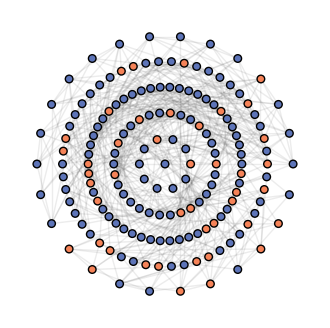

In [17]:
G = radial_plot(radius=1, regime="interpolation", seed=7)
pos = nx.get_node_attributes(G, 'pos')
signals = np.array([G.nodes[n]['signal'] for n in G.nodes()])
plt.figure(figsize=(4, 4))

nx.draw_networkx_nodes(G, pos, node_color=signals, **node_kwargs)
nx.draw_networkx_edges(G, pos, **edge_kwargs)
plt.axis('off')
plt.savefig('Fig2_A_interp_5.svg', bbox_inches='tight')
plt.savefig('Fig2_A_interp_5.png', bbox_inches='tight')
plt.show()

  0%|          | 0/167 [00:00<?, ?it/s]

100%|██████████| 167/167 [00:00<00:00, 15728.05it/s]


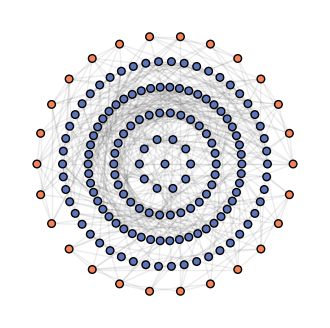

In [18]:
G = radial_plot(radius=1, regime="extrapolation")
pos = nx.get_node_attributes(G, 'pos')
signals = np.array([G.nodes[n]['signal'] for n in G.nodes()])
plt.figure(figsize=(4, 4))
nx.draw_networkx_nodes(G, pos, node_color=signals, **node_kwargs)
nx.draw_networkx_edges(G, pos, **edge_kwargs)
plt.axis('off')
plt.savefig('Fig2_A_extrap_5.svg', bbox_inches='tight')
plt.savefig('Fig2_A_extrap_5.png', bbox_inches='tight')
plt.show()